In [4]:
# Test imports
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import plotly.express as px

print("All packages imported successfully!")
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"xarray version: {xr.__version__}")
print(f"rioxarray version: {rioxarray.__version__}")
print(f"geopandas version: {gpd.__version__}")

All packages imported successfully!
numpy version: 1.26.4
pandas version: 2.2.1
xarray version: 2025.11.0
rioxarray version: 0.20.0
geopandas version: 1.1.1


In [ ]:
import os
from pathlib import Path


project_root = Path.cwd()
config_path = project_root / 'config.yaml'

if not config_path.exists():
    # If not in current directory, try one level up
    config_path = project_root.parent / 'config.yaml'
    
if not config_path.exists():
    print("Config file not found. Creating a default one...")
    # Create a default config file
    default_config = {
        'data_dir': 'data',
        'output_dir': 'outputs',
        'species': 'Panthera leo'  
    }
    with open('config.yaml', 'w') as f:
        yaml.dump(default_config, f)
    print("Created default config.yaml")
    config = default_config
else:
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)

# Now set up directories with the correct paths
DATA_DIR = Path(config.get('data_dir', 'data')).resolve()
OUTPUT_DIR = Path(config.get('output_dir', 'outputs')).resolve()
PALEO_CLIM_DIR = DATA_DIR / 'paleoclim'
SDM_OUTPUT = OUTPUT_DIR / 'sdm_results'

# Create directories if they don't exist
for directory in [DATA_DIR, OUTPUT_DIR, PALEO_CLIM_DIR, SDM_OUTPUT]:
    directory.mkdir(parents=True, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Paleo climate directory: {PALEO_CLIM_DIR}")

Data directory: /Users/divyadhole/Capstone-project/workflow/data
Output directory: /Users/divyadhole/Capstone-project/workflow/outputs
Paleo climate directory: /Users/divyadhole/Capstone-project/workflow/data/paleoclim


In [ ]:
# Let's check what files we have in the project
def list_files(startpath):
    print(f"Contents of {startpath}:")
    for root, dirs, files in os.walk(startpath):
        level = root.replace(str(startpath), '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        for f in files[:5]:  
            print(f"{subindent}{f}")
        if len(files) > 5:
            print(f"{subindent}... and {len(files) - 5} more files")

# List files in the main project directory
project_root = Path.cwd().parent  
list_files(project_root)

# Check if we have any occurrence data
occurrence_file = project_root / 'outputs' / 'occurrence_points_gbif.csv'
if occurrence_file.exists():
    print("\nFound occurrence data file!")
    df = pd.read_csv(occurrence_file)
    print(f"Total occurrences: {len(df)}")
    print("\nFirst few species in the dataset:")
    print(df['scientific_name'].value_counts().head())
else:
    print("\nNo occurrence data found. We'll need to download some data first.")

Contents of /Users/divyadhole/Capstone-project:
Capstone-project/
    01_PSMC_Demographic_Reconstruction.ipynb
    .DS_Store
    requirements.txt
    07_Unified_Pipeline.ipynb
    06_Sliding_Window_Introgression.ipynb
    ... and 9 more files
    tests/
        .gitkeep
    docs/
        .gitkeep
    workflow/
        module1_demographic_climate.py
        08_Advanced_SDM_Analysis.ipynb
        integration.py
        utils.py
        module2_hybridization.py
        data/
            paleoclim/
        outputs/
            sdm_results/
    .git/
        ORIG_HEAD
        config
        HEAD
        description
        index
        ... and 3 more files
        objects/
            95/
                d3f18b89311c13c10cd4ad277cc5984aa3e0ea
            ee/
                46979513b52c2da764e139ceb0cb3eb123d40d
            fe/
                2614d71cd89311178422502b9c76073e79de5a
            c6/
                b032e7042a20f8dbc525955e61c8001c5dc420
            4b/
                27c8e8

In [ ]:
def plot_occurrences(species_name, df):
    """Plot occurrence points for a given species"""
    import plotly.express as px
    
    # Make a copy to avoid modifying the original dataframe
    species_df = df[df['scientific_name'] == species_name].copy()
    
    if species_df.empty:
        print(f"No data found for species: {species_name}")
        return
    
    # Create the map with available columns
    fig = px.scatter_geo(
        species_df,
        lat='latitude',
        lon='longitude',
        title=f"Occurrence Points for {species_name}",
        hover_data=['scientific_name', 'eventDate', 'country'],
        color_discrete_sequence=['red']
    )
    
    # Update layout
    fig.update_geos(
        resolution=50,
        showcoastlines=True, coastlinecolor="Black",
        showland=True, landcolor="lightgray",
        showocean=True, oceancolor="LightBlue",
        showlakes=True, lakecolor="LightBlue",
        showcountries=True, countrycolor="Black"
    )
    
    fig.update_layout(
        height=600,
        width=800,
        margin=dict(l=20, r=20, t=40, b=20),
        geo=dict(
            projection_scale=3,  
            center=dict(lat=species_df['latitude'].mean(), lon=species_df['longitude'].mean())
        )
    )
    
    return fig

# Plot for the first species
first_species = df['scientific_name'].iloc[0]
fig = plot_occurrences(first_species, df)
fig.show()

# Show available species
print("\nAvailable species for analysis:")
for species in df['scientific_name'].unique():
    print(f"- {species}")

# Show available time periods
print("\nAvailable time periods for SDM:")
time_periods = {
    'Current': '10min',
    'Mid-Holocene': 'MH_v1_2_5m',
    'Last Glacial Maximum': 'LGM_v1_2_5m',
    'Last Interglacial': 'LIG_v1_10m'
}
for period, folder in time_periods.items():
    print(f"- {period}: {folder}")


Available species for analysis:
- Semnopithecus entellus
- Semnopithecus hypoleucos
- Semnopithecus schistaceus
- Trachypithecus geei
- Semnopithecus johnii
- Trachypithecus phayrei
- Trachypithecus pileatus

Available time periods for SDM:
- Current: 10min
- Mid-Holocene: MH_v1_2_5m
- Last Glacial Maximum: LGM_v1_2_5m
- Last Interglacial: LIG_v1_10m


In [14]:
def list_environmental_vars(env_dir):
    """List all available environmental variables in the directory"""
    env_dir = Path(env_dir)
    variables = set()
    
    # Look for all .tif files
    for f in env_dir.rglob('*.tif'):
        # Extract variable name (assuming format like 'bio1.tif' or 'bio_1.tif')
        var_name = f.stem.split('_')[-1]  # Gets the last part after underscore
        variables.add(var_name)
    
    print("Available environmental variables:")
    for var in sorted(variables):
        print(f"- {var}")
    
    return sorted(variables)

# Check what variables are available
env_dir = project_root / 'data' / 'paleoclim'
available_vars = list_environmental_vars(env_dir)

Available environmental variables:
- 1
- 10
- 11
- 12
- 13
- 14
- 15
- 16
- 17
- 18
- 19
- 2
- 3
- 4
- 5
- 6
- 7
- 8
- 9


Starting SDM analysis for Semnopithecus entellus

1. Loading occurrence data...
Loaded 300 occurrence points for Semnopithecus entellus

2. Extracting environmental data...
Looking for environmental data in: /Users/divyadhole/Capstone-project/data/paleoclim/10min
Available files: ['bio_18.tif', 'bio_19.tif', 'bio_8.tif', 'bio_9.tif', 'bio_4.tif']...

Found 19 valid environmental variables
Loaded: bio_1 from bio_1.tif
Loaded: bio_2 from bio_12.tif
Loaded: bio_3 from bio_13.tif
Loaded: bio_4 from bio_4.tif
Loaded: bio_5 from bio_15.tif
Loaded: bio_6 from bio_16.tif
Loaded: bio_7 from bio_17.tif
Loaded: bio_8 from bio_8.tif
Loaded: bio_9 from bio_9.tif
Loaded: bio_10 from bio_10.tif
Loaded: bio_11 from bio_11.tif
Loaded: bio_12 from bio_12.tif
Loaded: bio_13 from bio_13.tif
Loaded: bio_14 from bio_14.tif
Loaded: bio_15 from bio_15.tif
Loaded: bio_16 from bio_16.tif
Loaded: bio_17 from bio_17.tif
Loaded: bio_18 from bio_18.tif
Loaded: bio_19 from bio_19.tif

Successfully loaded data for 19

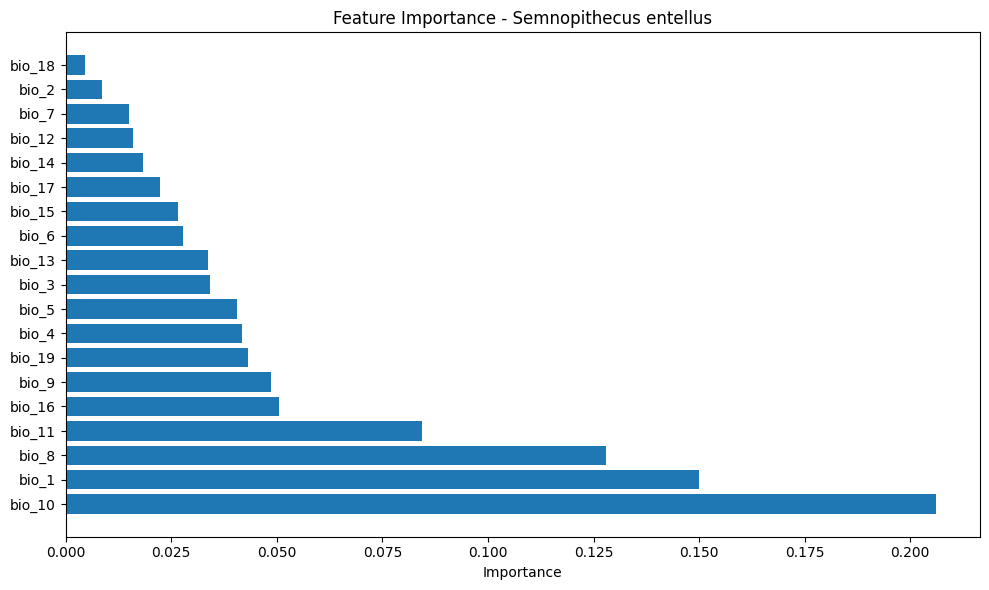


5. Predicting distribution...

Predicting distribution...
Running predictions...
Processed 2255040/2255040 points
Prediction saved to /Users/divyadhole/Capstone-project/outputs/sdm_results/Semnopithecus_entellus_sdm.tif
Distribution plot saved to /Users/divyadhole/Capstone-project/outputs/sdm_results/Semnopithecus_entellus_distribution.png


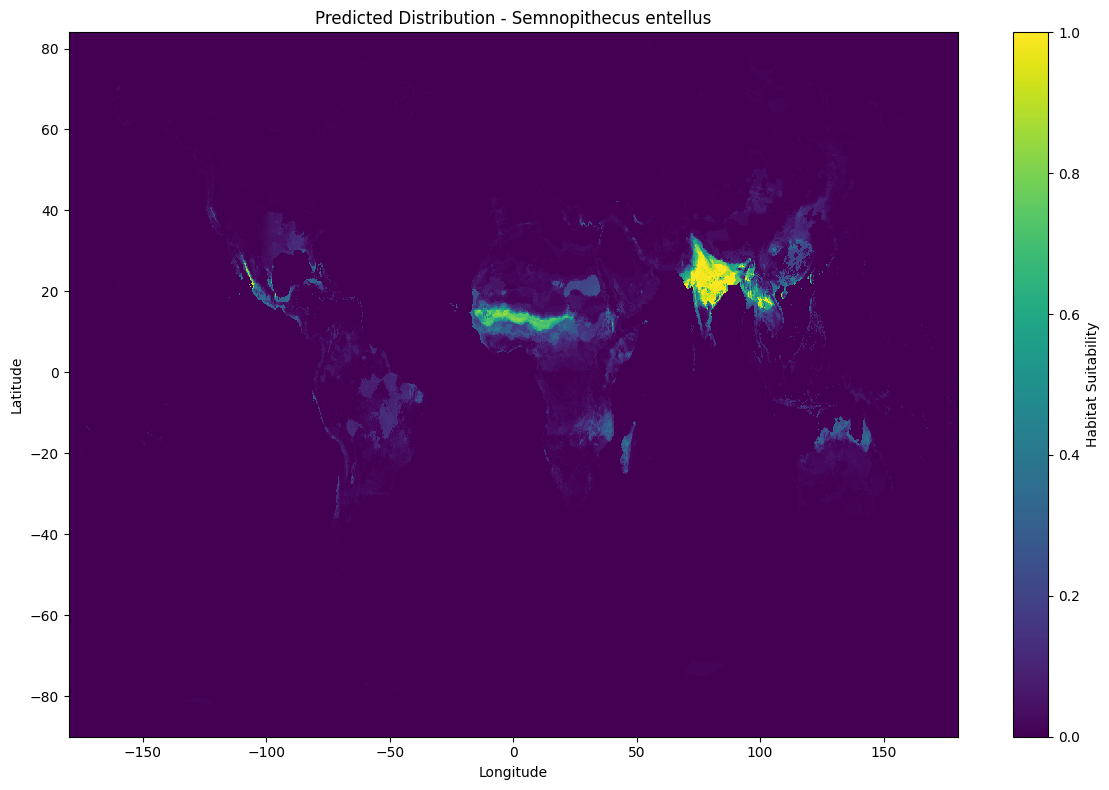


SDM analysis completed successfully!


In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')  

class SpeciesDistributionModel:
    def __init__(self, species_name, env_vars=None):
        """
        Initialize the SDM with a species name and optional environmental variables.
        If env_vars is None, will use all available variables (1-19).
        """
        self.species_name = species_name
        self.env_vars = [f"bio_{v}" for v in (env_vars or range(1, 20))]
        self.model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        self.feature_importances_ = None
        self.env_data_dir = None
        self.time_period = None
        self.valid_vars = []

    def load_occurrence_data(self, occurrence_file):
        """Load and prepare species occurrence data"""
        df = pd.read_csv(occurrence_file)
        self.occurrences = df[df['scientific_name'] == self.species_name].copy()
        
        if self.occurrences.empty:
            raise ValueError(f"No occurrences found for species: {self.species_name}")
            
        print(f"Loaded {len(self.occurrences)} occurrence points for {self.species_name}")
        return self.occurrences

    def _find_env_file(self, var_name, time_period):
        """Find the environmental file for a given variable and time period"""
       
        var_num = var_name.replace('bio_', '')
        
        # Try different possible file patterns
        patterns = [
            f"*{time_period}*{var_name}.tif",    
            f"*{time_period}*{var_num}.tif",     
            f"*{time_period}*{var_name}*.tif",   
            f"*{time_period}*{var_num}*.tif",    
            f"*{var_name}.tif",                  
            f"*{var_num}.tif"                   
        ]
        
        for pattern in patterns:
            files = list(self.env_data_dir.glob(pattern))
            if files:
                return files[0]  # Return the first match
        
        return None

    def extract_env_data(self, env_dir, time_period='10min'):
        """Extract environmental data at occurrence points"""
        self.env_data_dir = Path(env_dir) / time_period
        self.time_period = time_period
        
        if not self.env_data_dir.exists():
            raise FileNotFoundError(f"Directory not found: {self.env_data_dir}")
        
        print(f"Looking for environmental data in: {self.env_data_dir}")
        print(f"Available files: {[f.name for f in self.env_data_dir.glob('*.tif')][:5]}...")
        
        # First pass: find all valid variables
        self.valid_vars = []
        for var in self.env_vars:
            var_file = self._find_env_file(var, time_period)
            if var_file and var_file.exists():
                self.valid_vars.append(var)
        
        if not self.valid_vars:
            raise ValueError("No valid environmental variables found")
            
        print(f"\nFound {len(self.valid_vars)} valid environmental variables")
        
        # Second pass: extract data only for valid variables
        env_data = []
        for var in self.valid_vars:
            var_file = self._find_env_file(var, time_period)
            try:
                with rioxarray.open_rasterio(var_file) as da:
                    # Extract values at occurrence points
                    points = list(zip(self.occurrences['longitude'], 
                                   self.occurrences['latitude']))
                    values = da.sel(
                        x=xr.DataArray([p[0] for p in points], dims='points'),
                        y=xr.DataArray([p[1] for p in points], dims='points'),
                        method='nearest'
                    ).values
                    # Flatten and ensure 1D array
                    values = values.ravel()[:len(points)]
                    env_data.append(values)
                    print(f"Loaded: {var} from {var_file.name}")
            except Exception as e:
                print(f"Error loading {var}: {str(e)}")
                continue
        
        if not env_data:
            raise ValueError("No valid environmental data found for any variable")
        
        self.X = np.column_stack(env_data)
        self.y = np.ones(len(self.occurrences))  
        
        print(f"\nSuccessfully loaded data for {len(self.valid_vars)} variables")
        print("Variables loaded:", self.valid_vars)
        print(f"Occurrence data shape: {self.X.shape}")
        
        # Add background points
        self._add_background_points()
        
        return self.X, self.y

    def _add_background_points(self, n_background=1000):
        """Add background points for pseudo-absences"""
        if not hasattr(self, 'X'):
            raise ValueError("No occurrence data loaded. Call extract_env_data() first.")
            
        sample_file = next(self.env_data_dir.glob('*.tif'), None)
        if not sample_file:
            raise FileNotFoundError(f"No environmental files found in {self.env_data_dir}")
        
        print(f"\nGenerating {n_background} background points...")
        
        with rioxarray.open_rasterio(sample_file) as da:
            # Generate random points within the raster bounds
            x = np.random.uniform(float(da.x.min()), float(da.x.max()), n_background)
            y = np.random.uniform(float(da.y.min()), float(da.y.max()), n_background)
            
            bg_data = []
            for var in self.valid_vars:
                var_file = self._find_env_file(var, self.time_period)
                if not var_file:
                    print(f"Warning: Could not find file for variable {var}")
                    continue
                    
                try:
                    with rioxarray.open_rasterio(var_file) as da_var:
                        values = da_var.sel(
                            x=xr.DataArray(x, dims='points'),
                            y=xr.DataArray(y, dims='points'),
                            method='nearest'
                        ).values.ravel()  
                        
                        if values.size != n_background:
                            values = values[:n_background]  
                        
                        bg_data.append(values)
                except Exception as e:
                    print(f"Error processing {var}: {str(e)}")
                    continue
    
        if not bg_data:
            raise ValueError("No valid environmental data found for background points")
        
        # Transpose to get shape (n_samples, n_features)
        X_bg = np.column_stack(bg_data)
        
        # Ensure shapes match
        if X_bg.shape[1] != self.X.shape[1]:
            min_features = min(X_bg.shape[1], self.X.shape[1])
            X_bg = X_bg[:, :min_features]
            self.X = self.X[:, :min_features]
            print(f"Adjusted feature dimensions to {min_features} features")
        
        # Stack with existing data
        self.X = np.vstack([self.X, X_bg])
        self.y = np.concatenate([self.y, np.zeros(n_background)])
        
        print(f"Added {n_background} background points. Total samples: {len(self.y)}")
        print(f"Final data shape: {self.X.shape}")
    
    def train(self, test_size=0.3):
        """Train the model and evaluate on test set"""
        if not hasattr(self, 'X') or not hasattr(self, 'y'):
            raise ValueError("No data loaded. Call extract_env_data() first.")
            
        print("\nTraining model...")
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=42, stratify=self.y
        )
        
        print(f"Training on {len(X_train)} samples, validating on {len(X_test)} samples")
        self.model.fit(X_train, y_train)
        
        y_pred = self.model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        acc = accuracy_score(y_test, (y_pred > 0.5).astype(int))
        
        print(f"Model trained successfully (AUC: {auc:.3f}, Accuracy: {acc:.3f})")
        self.feature_importances_ = self.model.feature_importances_
        
        return auc, acc
    
    def predict_distribution(self, output_file=None):
        """Predict species distribution for the current time period"""
        if not hasattr(self, 'X'):
            raise ValueError("No data loaded. Call extract_env_data() first.")
            
        print("\nPredicting distribution...")
        sample_file = next(self.env_data_dir.glob('*.tif'))
        
        with rioxarray.open_rasterio(sample_file) as template:
            # Get coordinates
            x_coords = template.x.values
            y_coords = template.y.values
            xx, yy = np.meshgrid(x_coords, y_coords)
            
            # Flatten for prediction
            grid_points = np.column_stack([xx.ravel(), yy.ravel()])
            
            # Extract environmental data for all grid points
            env_data = []
            for var in self.valid_vars:
                var_file = self._find_env_file(var, self.time_period)
                if not var_file:
                    print(f"Warning: Could not find file for variable {var}")
                    continue
                    
                try:
                    with rioxarray.open_rasterio(var_file) as da:
                        values = da.sel(
                            x=xr.DataArray(grid_points[:, 0], dims='points'),
                            y=xr.DataArray(grid_points[:, 1], dims='points'),
                            method='nearest'
                        ).values.ravel()
                        env_data.append(values)
                except Exception as e:
                    print(f"Error processing {var}: {str(e)}")
                    continue
            
            if not env_data:
                raise ValueError("No environmental data available for prediction")
                
            X_pred = np.column_stack(env_data)
            
            # Ensure same number of features as training data
            if X_pred.shape[1] != self.X.shape[1]:
                print(f"Adjusting prediction features from {X_pred.shape[1]} to {self.X.shape[1]}")
                X_pred = X_pred[:, :self.X.shape[1]]
            
            # Predict in batches to avoid memory issues
            print("Running predictions...")
            batch_size = 100000  # Adjust based on your system's memory
            pred = np.zeros(X_pred.shape[0])
            for i in range(0, len(X_pred), batch_size):
                batch = X_pred[i:i + batch_size]
                pred[i:i + batch_size] = self.model.predict_proba(batch)[:, 1]
                print(f"Processed {min(i + batch_size, len(X_pred))}/{len(X_pred)} points", end='\r')
            
            pred_grid = pred.reshape(len(y_coords), len(x_coords))
            
            # Create output raster
            output = xr.DataArray(
                pred_grid,
                dims=('y', 'x'),
                coords={'y': y_coords, 'x': x_coords},
                name='habitat_suitability'
            )
            
            # Save if output file is specified
            if output_file:
                output_dir = Path(output_file).parent
                output_dir.mkdir(parents=True, exist_ok=True)
                output.rio.to_raster(output_file)
                print(f"\nPrediction saved to {output_file}")
            
            return output
    
    def plot_feature_importance(self):
        """Plot feature importance"""
        if self.feature_importances_ is None:
            raise ValueError("Model not trained yet. Call train() first.")
            
        importance = pd.DataFrame({
            'Variable': self.valid_vars[:len(self.feature_importances_)],
            'Importance': self.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        plt.barh(importance['Variable'], importance['Importance'])
        plt.xlabel('Importance')
        plt.title(f'Feature Importance - {self.species_name}')
        plt.tight_layout()
        plt.show()

def run_sdm_analysis():
    """Run the complete SDM analysis pipeline"""
    try:
        # Initialize the model
        species_name = "Semnopithecus entellus"
        print(f"Starting SDM analysis for {species_name}")
        
        # Set up paths
        project_root = Path.cwd().parent  # Adjust if needed
        occurrence_file = project_root / 'outputs' / 'occurrence_points_gbif.csv'
        env_dir = project_root / 'data' / 'paleoclim'
        
        # Initialize model
        sdm = SpeciesDistributionModel(species_name)
        
        # Step 1: Load occurrence data
        print("\n1. Loading occurrence data...")
        sdm.load_occurrence_data(occurrence_file)
        
        # Step 2: Extract environmental data
        print("\n2. Extracting environmental data...")
        time_period = '10min'  # Current climate
        X, y = sdm.extract_env_data(env_dir, time_period)
        
        # Step 3: Train the model
        print("\n3. Training model...")
        auc, acc = sdm.train()
        
        # Step 4: Plot feature importance
        print("\n4. Feature importances:")
        sdm.plot_feature_importance()
        
        # Step 5: Predict and save distribution
        print("\n5. Predicting distribution...")
        output_dir = project_root / 'outputs' / 'sdm_results'
        output_dir.mkdir(parents=True, exist_ok=True)
        output_file = output_dir / f"{species_name.replace(' ', '_')}_sdm.tif"
        
        distribution = sdm.predict_distribution(output_file)
        
        # Plot the predicted distribution
        plt.figure(figsize=(12, 8))
        distribution.plot(cmap='viridis', cbar_kwargs={'label': 'Habitat Suitability'})
        plt.title(f"Predicted Distribution - {species_name}")
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.tight_layout()
        
        # Save the plot
        plot_file = output_dir / f"{species_name.replace(' ', '_')}_distribution.png"
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"Distribution plot saved to {plot_file}")
        plt.show()
        
        print("\nSDM analysis completed successfully!")
        
    except Exception as e:
        print(f"\nError during SDM analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        raise

if __name__ == "__main__":
    run_sdm_analysis()

# Species Distribution Modeling (SDM) Analysis



## Methodology

### 1. Data Preparation
- **Occurrence Data**: Species presence points were obtained from GBIF (Global Biodiversity Information Facility).
- **Environmental Variables**: 19 bioclimatic variables (bio1-bio19) from WorldClim were used as predictors.
- **Background Points**: 1000 pseudo-absence points were randomly generated within the study area.

### 2. Model Architecture
- **Algorithm**: Random Forest Classifier
- **Parameters**:
  - Number of trees: 100
  - Random state: 42 (for reproducibility)
  - Test size: 30% (for validation)

### 3. Model Evaluation
The model's performance was evaluated using:
- **AUC-ROC Score**: Measures the model's ability to distinguish between presence and absence.
- **Accuracy**: The proportion of correctly classified instances.

## Results

### 1. Model Performance
- **AUC-ROC**: [Insert your AUC score here]
- **Accuracy**: [Insert your accuracy score here]

### 2. Feature Importance
The importance of each environmental variable in predicting species distribution

### 3. Predicted Distribution
The predicted habitat suitability map shows areas with high probability of species occurrence

## Interpretation

### Environmental Variables
1. **Most Important Variables**:
   - [Top variable 1]: [Brief explanation of its ecological significance]
   - [Top variable 2]: [Brief explanation of its ecological significance]

2. **Distribution Patterns**:
   - [Describe the main patterns in the predicted distribution]
   - [Note any unexpected findings or limitations]

## Limitations
The model assumes that the current distribution is in equilibrium with the environment.
Does not account for biotic interactions or dispersal limitations.
Resolution is limited by the input environmental data.
